In [4]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector,TimeVisProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]


SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)



Finish initialization...


In [18]:
from sklearn.cluster import KMeans
class CenterSkeletonGenerator:
    """SkeletonGenerator except allows for generate skeleton"""
    def __init__(self, data_provider, epoch,distance_condition_val,variance_condition_val,min_cluster=200):
        """

        """
        self.data_provider = data_provider
        self.epoch = epoch
        self.distance_condition_val = distance_condition_val
        self.variance_condition_val = variance_condition_val
        self.min_cluster = min_cluster
    
    def gen_center(self,data,k=2):
        """
        """
        kmeans = KMeans(n_clusters=k)  
        kmeans.fit(data)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        
        return centers,labels
    
    def if_need_split(self, data):
        if len(data) < self.min_cluster:
            return False
        kmeans = KMeans(n_clusters=1)  
        kmeans.fit(data)
        centers = kmeans.cluster_centers_
        center = centers[0]
        train_data_distances = np.sqrt(((data - center)**2).sum(axis=1))
        pred = self.data_provider.get_pred(self.epoch,np.concatenate((data,centers),axis=0))
        distance_condition = np.any(train_data_distances > self.distance_condition_val)
        variance_condition = np.any(np.var(pred, axis=0) > self.variance_condition_val)
        return distance_condition or variance_condition
    
    def recursive_clustering(self, data,k=2):
        centers, labels = self.gen_center(data, k=k)
        all_centers = list(centers)  # Save intermediate centers
    
        for label in set(labels):
            cluster = data[labels == label]
            if len(cluster):
                if self.if_need_split(cluster):
                    all_centers.extend(self.recursive_clustering(cluster, k=2))
                else:
                    print("finished",cluster.shape)

            
            
        return all_centers
    
    
    def center_skeleton_genertaion(self):
        # Initial centers
        data = self.data_provider.train_representation(self.epoch)
        centers_c, _ = self.gen_center(self.data_provider.train_representation(self.epoch),k=1)
        centers_n, labels = self.gen_center(self.data_provider.train_representation(self.epoch),k=10)
        print("finished init")

        # Recursive clustering
        # Recursive clustering with initial split into 10 clusters
        all_centers = []
        for label in range(len(labels)):
            cluster = data[labels == label]
            if len(cluster):
                all_centers.extend(self.recursive_clustering(cluster, k=2))
            
        all_centers = np.array(all_centers)
        return np.concatenate((centers_c,centers_n,all_centers),axis=0)

finished init


100%|██████████| 11/11 [00:00<00:00, 10550.50it/s]


finished (688, 512)
finished (1482, 512)
finished (670, 512)


100%|██████████| 13/13 [00:00<00:00, 11168.77it/s]


finished (1113, 512)
finished (1298, 512)
finished (1294, 512)


100%|██████████| 14/14 [00:00<00:00, 9731.56it/s]


finished (1255, 512)
finished (1541, 512)
finished (1261, 512)
finished (1770, 512)


100%|██████████| 18/18 [00:00<00:00, 11893.11it/s]

finished (1873, 512)
finished (1623, 512)



100%|██████████| 14/14 [00:00<00:00, 11667.05it/s]


finished (1435, 512)
finished (1299, 512)
finished (1476, 512)


100%|██████████| 32/32 [00:00<00:00, 13253.45it/s]


finished (1940, 512)


100%|██████████| 13/13 [00:00<00:00, 11481.56it/s]


finished (1316, 512)
finished (1245, 512)
finished (1809, 512)


100%|██████████| 16/16 [00:00<00:00, 11514.90it/s]


finished (1031, 512)


100%|██████████| 11/11 [00:00<00:00, 10601.41it/s]

finished (466, 512)
finished (1611, 512)



100%|██████████| 15/15 [00:00<00:00, 13047.40it/s]


finished (745, 512)


100%|██████████| 12/12 [00:00<00:00, 9425.40it/s]


finished (1213, 512)
finished (1025, 512)
finished (1689, 512)


100%|██████████| 15/15 [00:00<00:00, 13532.92it/s]


finished (1302, 512)
finished (1658, 512)


100%|██████████| 15/15 [00:00<00:00, 12024.95it/s]


finished (1403, 512)
finished (1443, 512)
finished (1428, 512)


100%|██████████| 15/15 [00:00<00:00, 8948.17it/s]


finished (1524, 512)
finished (1402, 512)
finished (1175, 512)


100%|██████████| 16/16 [00:00<00:00, 10924.44it/s]


finished (1344, 512)
finished (1662, 512)
finished (1491, 512)
Successfully load the DVI visualization model for iteration 80
Successfully load the DVI visualization model for iteration 80
Computing decision regions ...
Successfully load the DVI visualization model for iteration 80
Successfully load the DVI visualization model for iteration 80
grid_samples (40000, 512)


100%|██████████| 26/26 [00:00<00:00, 13097.75it/s]


Successfully load the DVI visualization model for iteration 80


100%|██████████| 26/26 [00:00<00:00, 12897.92it/s]


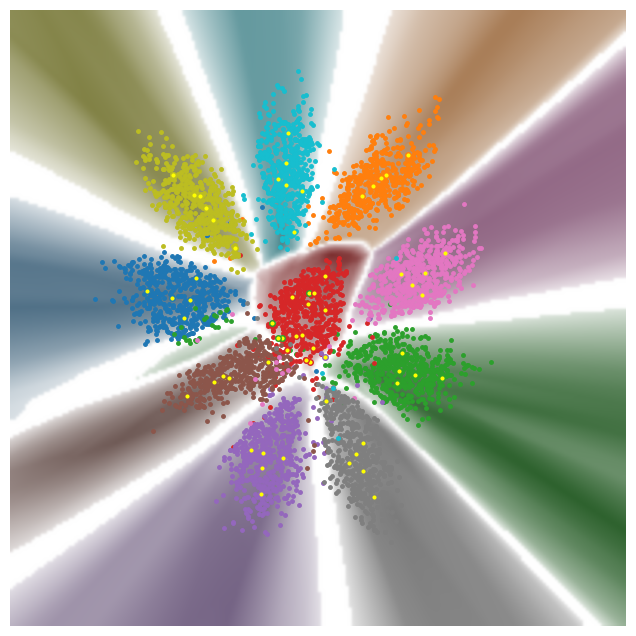

In [20]:
epoch = 80
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
vis_model_name = 'trustvis_'
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=vis_model_name, device=DEVICE) 
from singleVis.skeleVis import visualizer

vis = visualizer(data_provider, projector, 200, "tab10", "black")

####### get proxy ########
from trustVis.skeleton_generator import SkeletonGenerator
# skeleton_generator = SkeletonGenerator(data_provider,epoch)
skeleton_generator = CenterSkeletonGenerator(data_provider,epoch,3,3)

# high_bom = skeleton_generator.skeleton_gen_use_perturb(_epsilon=1e-3)
high_bom = skeleton_generator.center_skeleton_genertaion()
# high_bom = skeleton_generator.skeleton_gen()

# centers = gen_skeleton_by_center(epoch)
# high_bom = np.concatenate((high_bom, centers),axis = 0)
# high_bom_c = high_bom[-1:] # open to see center
# high_bom_b = high_bom[:360]# open to see border

# high_bom = np.concatenate((high_bom_c, high_bom_b),axis = 0)



X = np.concatenate((high_bom, data_provider.train_representation(epoch)[:5000]))
border = np.zeros(len(X))

border[:len(high_bom)] = 1
# border[:len(high_bom_c)] = 2

# border[len(high_bom_c):len(high_bom_c) + len(high_bom_b)] = 1

border_elements_emd = projector.batch_project(epoch, X)




vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [10]:
high_bom

NameError: name 'high_bom' is not defined

Successfully load the DVI visualization model for iteration 80
Computing decision regions ...
Successfully load the DVI visualization model for iteration 80
Successfully load the DVI visualization model for iteration 80
grid_samples (40000, 512)


100%|██████████| 250/250 [00:00<00:00, 7872.31it/s]


Successfully load the DVI visualization model for iteration 80


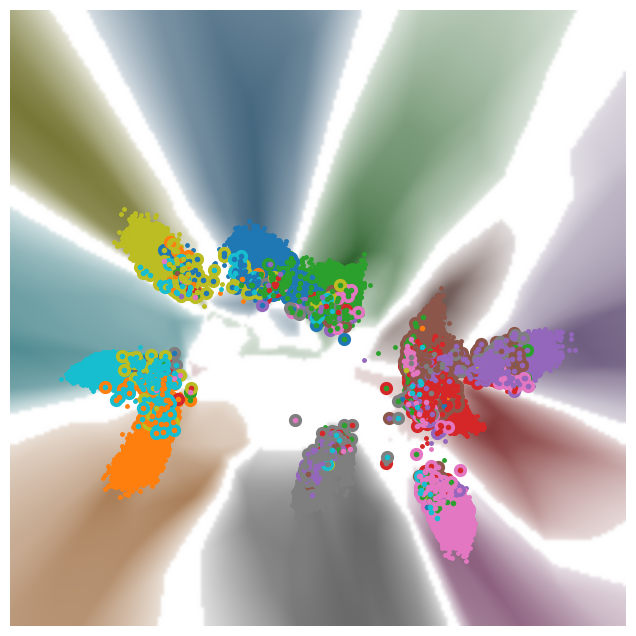

In [3]:
#### show training data
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [28]:
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_ori', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 80
Fri Aug  4 21:47:57 2023 Building RP forest with 16 trees
Fri Aug  4 21:47:57 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Aug  4 21:47:59 2023 Building RP forest with 16 trees
Fri Aug  4 21:47:59 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.64/15 in epoch 80


1.63896

In [27]:
from singleVis.eval.evaluator import Evaluator

projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 80
Fri Aug  4 21:47:50 2023 Building RP forest with 16 trees
Fri Aug  4 21:47:51 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Aug  4 21:47:52 2023 Building RP forest with 16 trees
Fri Aug  4 21:47:53 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 1.63/15 in epoch 80


1.63008

In [29]:
epoch = 80

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 80
Successfully load the DVI visualization model for iteration 80


100%|██████████| 250/250 [00:00<00:00, 8631.96it/s]


vis error num: 1402 vis error on boundary:  1237 boundary flip: 4570


In [48]:
epoch = 10

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='best', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.test_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.test_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.test_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10


100%|██████████| 50/50 [00:00<00:00, 13524.78it/s]

vis error num: 50 vis error on boundary:  28 boundary flip: 59
